In [1]:
import os
from os import chdir
# chdir('/Users/jihyun/Desktop/postech/bigdata
os.getcwd()

'/Users/jihyun/Desktop/postech/bigdata'

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

from sklearn.preprocessing import scale,robust_scale,minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [3]:
ds_scale=pd.read_csv('SCALE불량.csv',encoding='CP949')
ds_scale.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


In [4]:
ds_scale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 21 columns):
PLATE_NO             720 non-null object
ROLLING_DATE         720 non-null object
SCALE                720 non-null object
SPEC                 720 non-null object
STEEL_KIND           720 non-null object
PT_THK               720 non-null float64
PT_WDTH              720 non-null int64
PT_LTH               720 non-null int64
PT_WGT               720 non-null int64
FUR_NO               720 non-null object
FUR_NO_ROW           720 non-null int64
FUR_HZ_TEMP          720 non-null int64
FUR_HZ_TIME          720 non-null int64
FUR_SZ_TEMP          720 non-null int64
FUR_SZ_TIME          720 non-null int64
FUR_TIME             720 non-null int64
FUR_EXTEMP           720 non-null int64
ROLLING_TEMP_T5      720 non-null int64
HSB                  720 non-null object
ROLLING_DESCALING    720 non-null int64
WORK_GR              720 non-null object
dtypes: float64(1), int64(12), object(8)
memo

* 불량 데이터(ds_scale)는 720개의 관측치와 21개의 변수로 이루어져 있다.
* 총 21개의 변수는 불량 유무(SCALE:0(양품), 1(불량))와 이에 영향을 미칠 것으로 예상되는 20개의 변수로 구성되어 있다.

In [5]:
cols=ds_scale.columns[2:]
ds_scale=ds_scale[cols]

# FUR_SZ_TEMP - FUR_EXTEM 동일
ds_scale.drop('FUR_EXTEMP',axis=1,inplace=True)

In [6]:
# 목표변수 더미화
ds_scale.loc[ds_scale['SCALE']=='불량','SCALE']=1
ds_scale.loc[ds_scale['SCALE']=='양품','SCALE']=0

# 데이터 타입 일치
ds_scale['FUR_NO_ROW']=ds_scale['FUR_NO_ROW'].astype(object)

* 20개의 설명변수 중 불량 유무에 영향을 미치지 않는 id 변수(PLATE_NO), 분석 대상이 아닌 작업시간변수(ROLLING_DATE)와 중복변수인 압연온도(FUR_EXTEM)를 제외하고 11개의 연속형 변수와 6개의 범주형 변수, 총 17개의 설명변수로 SCALE불량의 원인을 찾고자 한다.
* 목표변수를 더미화 시켜주고 변수들의 데이터 타입을 맞춘 후 데이터 탐색을 시행한다.

# (1)  EDA기반 원인변수 탐색

### 1. 목표변수

0    0.679167
1    0.320833
Name: SCALE, dtype: float64


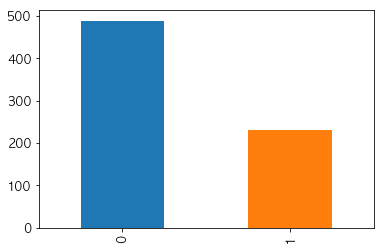

In [7]:
ds_scale['SCALE'].value_counts().plot(kind='bar')
print(ds_scale['SCALE'].value_counts(normalize=True))

SCALE 양품(0)대 불량(1)의 비는 68:32로 양품이 불량보다 약 1.8배 정도 많은 비율로 존재한다.
다음으로, 연속형 변수인 설명변수들의 분포를 살펴보자.

### 2. 연속형 설명변수  

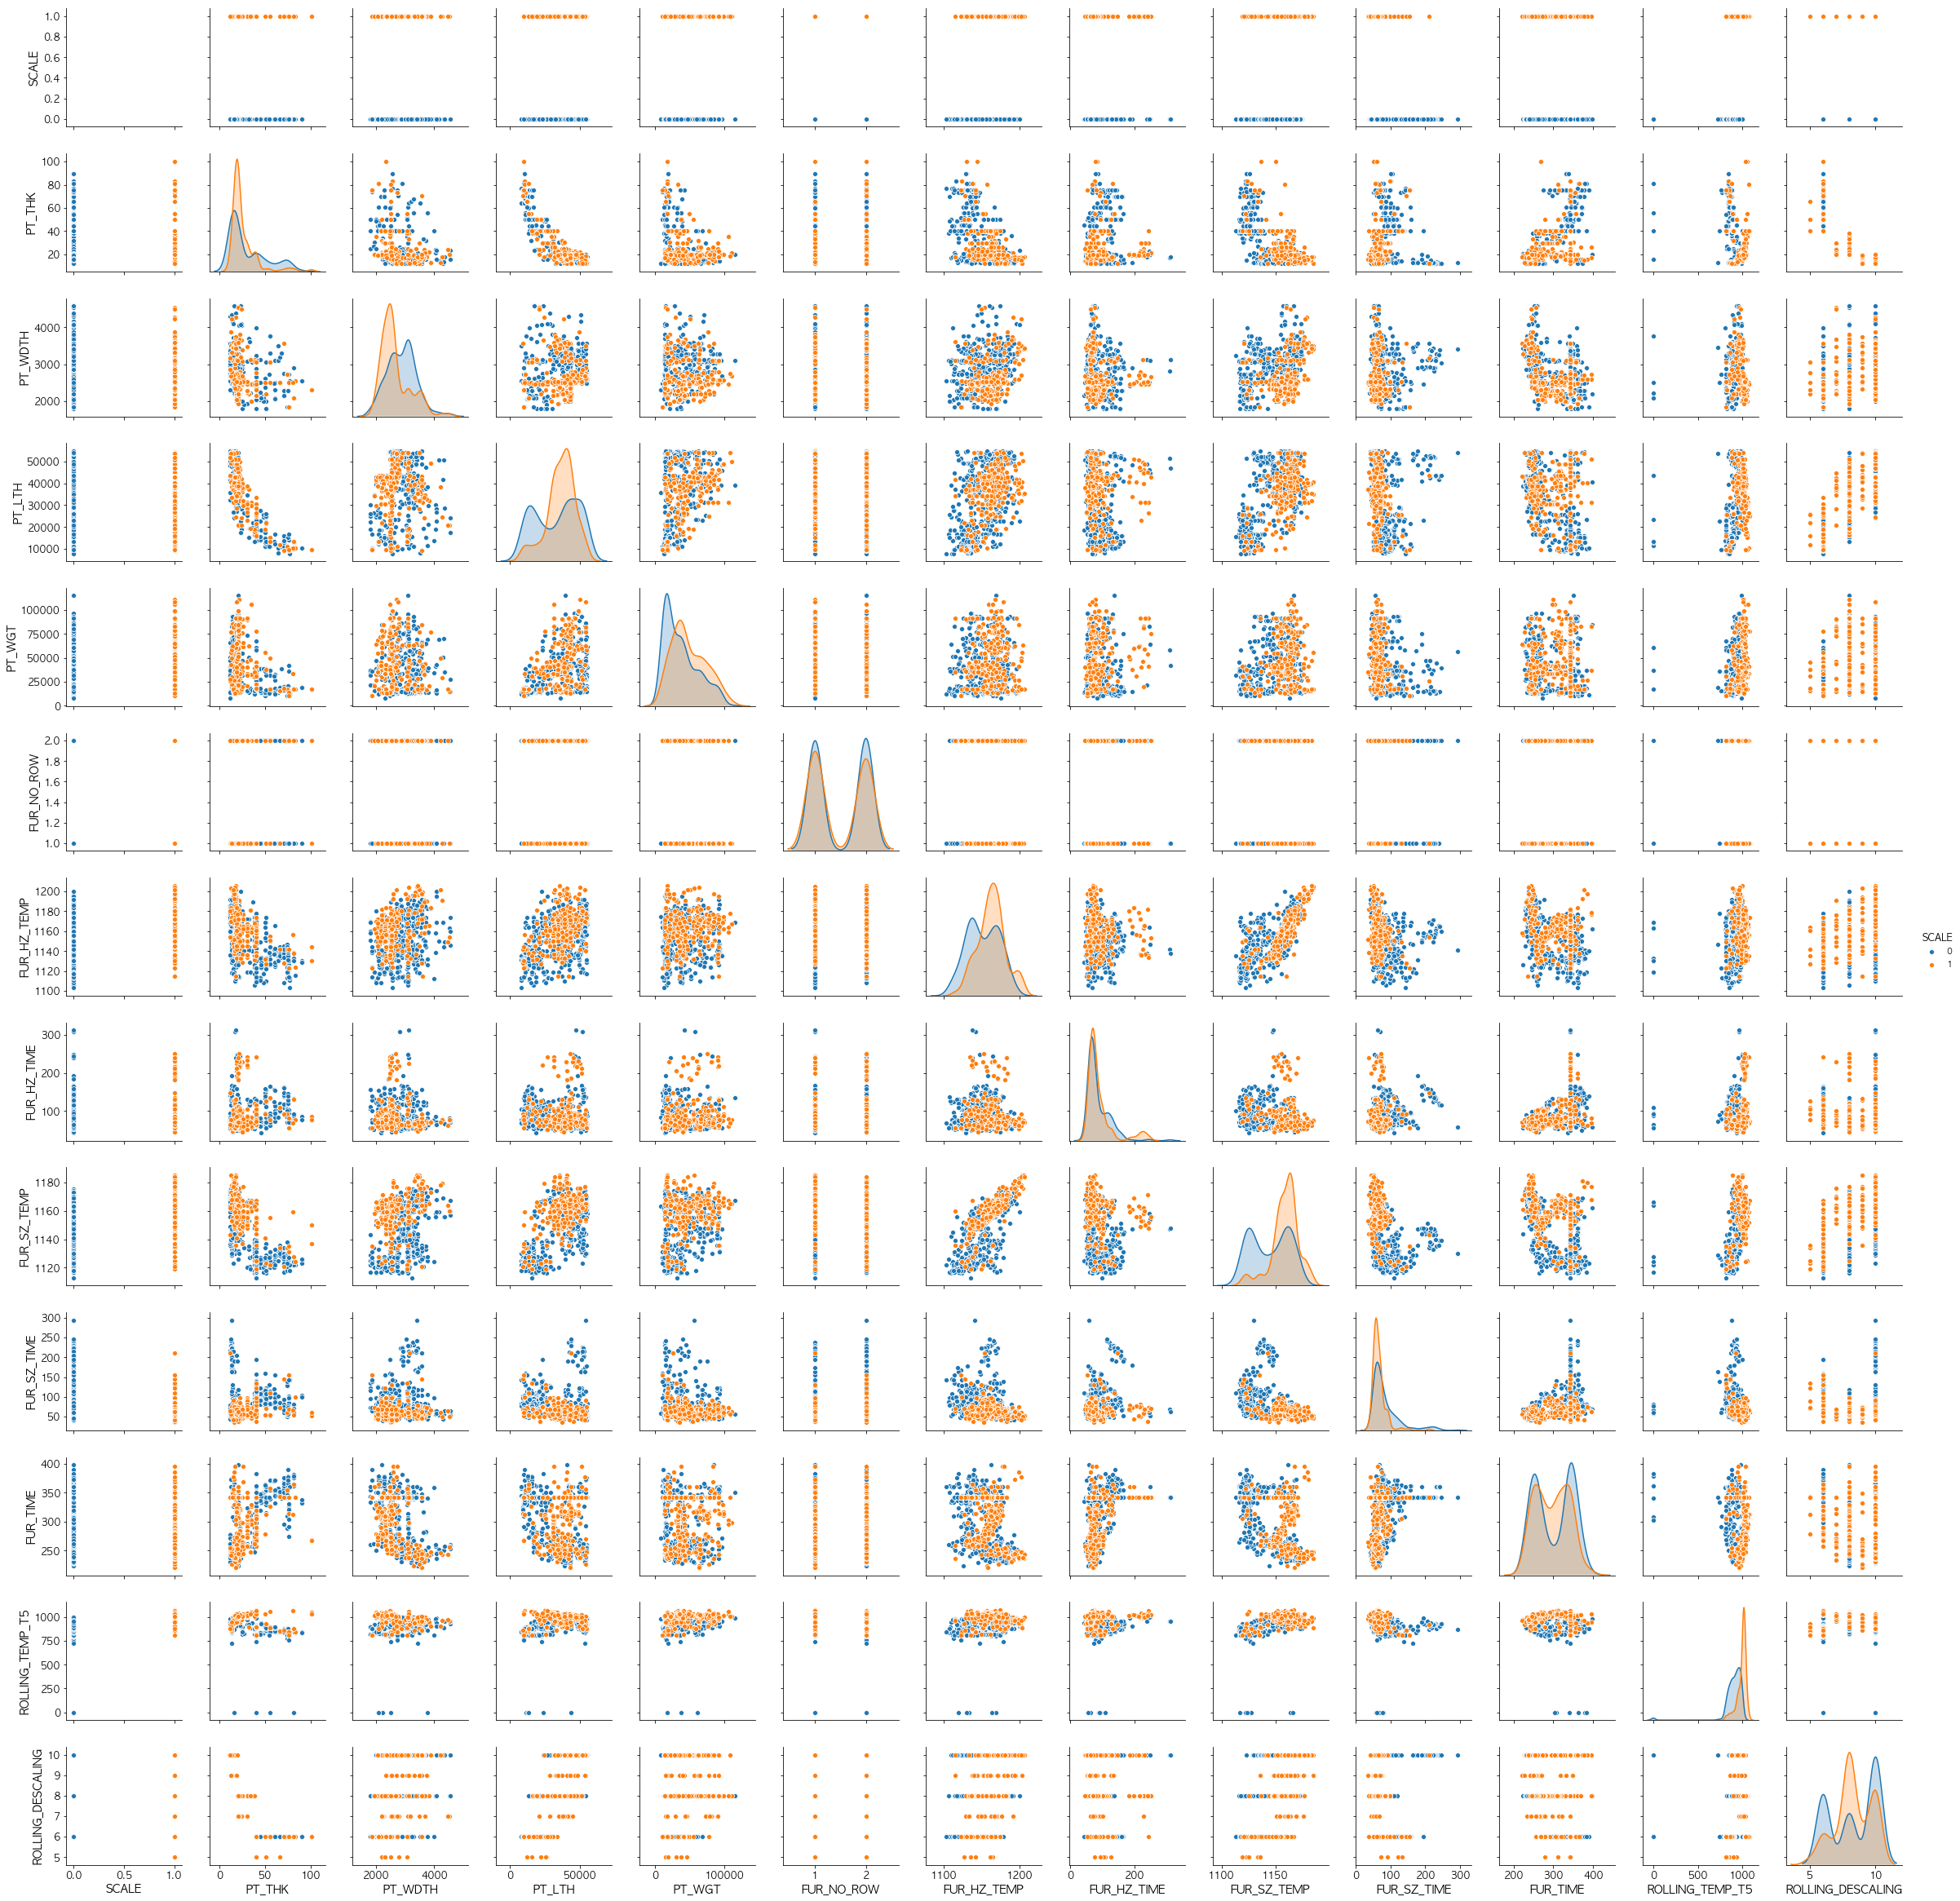

In [8]:
sns.pairplot(kind='scatter',hue='SCALE',data=ds_scale)

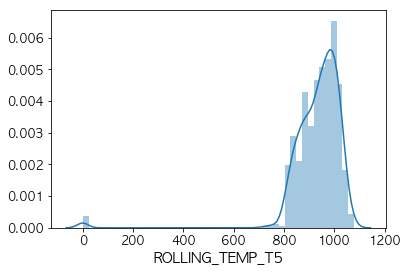

In [9]:
sns.distplot(ds_scale['ROLLING_TEMP_T5'])
ds_scale=ds_scale[ds_scale['ROLLING_TEMP_T5']>200]

가열대 온도(ROLLING_TEMP_T5) 에서 0의 값을 갖는 6개의 이상치가 감지된다. 따라서 분석에 앞서 이를 제거한다.

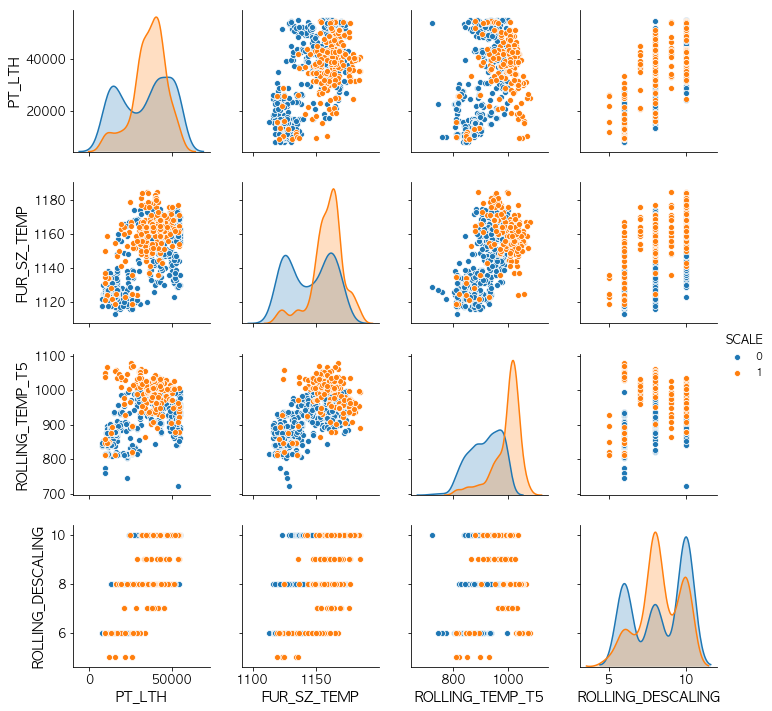

In [10]:
sns.pairplot(kind='scatter',hue='SCALE',data=ds_scale,
             vars=['PT_LTH','FUR_SZ_TEMP','ROLLING_TEMP_T5','ROLLING_DESCALING'])

연속형 단변수 분포를 보면 

FT_LTH/ FUR_SZ_TEMP/ ROLLING_TEMP_T5 / ROLLING_DESCALING 에서 불량과 양품의 차이가 눈에 띈다.
* plate길이가 길 때 / 가열로 균열대 온도가 높을 때 / 가열대 온도가 높을 때 불량이 높다.
* 압연중 디스케일링 횟수에서는 양품과 불량에서 다른 추세로 나타나므로 특정 SPEC 등 다른 설명변수와 결합하여 나타난 결과일 것이라 예상된다.

### 3. 범주형 설명변수

In [11]:
ds_scale.select_dtypes(include='object').columns

Index(['SPEC', 'STEEL_KIND', 'FUR_NO', 'FUR_NO_ROW', 'HSB', 'WORK_GR'], dtype='object')

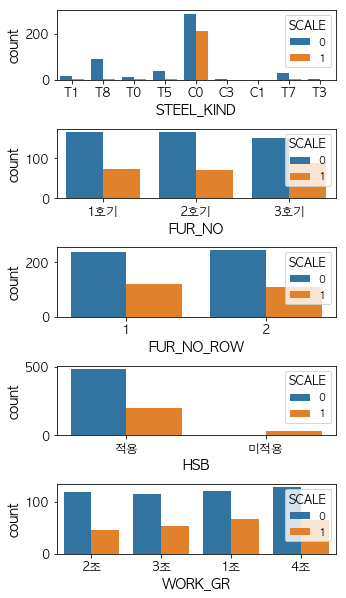

In [12]:
fig, axes = plt.subplots(nrows=5,figsize=(5,10))
fig.subplots_adjust(hspace=0.7)

sns.countplot(x='STEEL_KIND',hue='SCALE',data=ds_scale, ax=axes[0])
sns.countplot(x='FUR_NO',hue='SCALE',data=ds_scale, ax=axes[1])
sns.countplot(x='FUR_NO_ROW',hue='SCALE',data=ds_scale, ax=axes[2])
sns.countplot(x='HSB',hue='SCALE',data=ds_scale, ax=axes[3])
sns.countplot(x='WORK_GR',hue='SCALE',data=ds_scale, ax=axes[4])

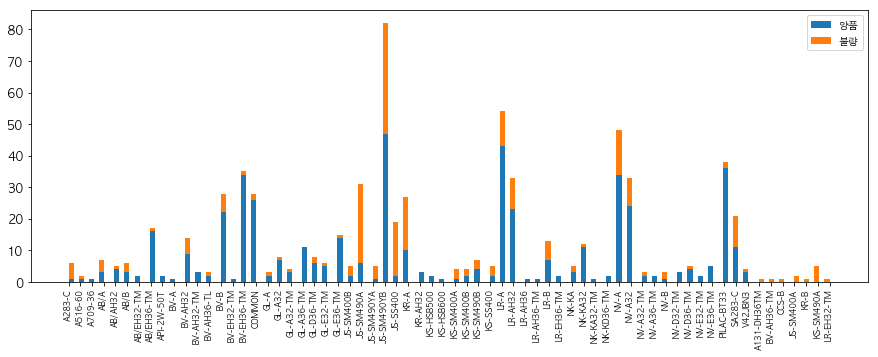

In [13]:
plt.figure(figsize=(15,5))
plt.xticks(rotation='vertical',size=8)
ds_scale_sortedby_SPEC=ds_scale.sort_values('SPEC')
plt.hist([ ds_scale_sortedby_SPEC[ds_scale_sortedby_SPEC['SCALE']==0]['SPEC'],
         ds_scale_sortedby_SPEC[ds_scale_sortedby_SPEC['SCALE']==1]['SPEC'] ],
         stacked=True,bins=150);
plt.legend(['양품','불량'])

범주형 변수에서는 SPEC이 불량과 양품에 차이를 줄 것으로 예상된다.
* 높은 불량 = A / JS / KR / LR / NV
* 낮은 불량 = BV / GL / NV

같은 대분류 스펙 안에서도 세부 스펙마다 불량률이 다르기 때문에 관심 스펙이 있다면 이를 주로 분석함도 필요할 것으로 생각된다.

추가적으로, STEEL_KIND(C0)와 HSB(적용)이 관측치 대부분이므로 후의 분석에서 이를 고려하여 판단해야 한다.

#### 최종적으로, 데이터 탐색을 통해서 5개의 설명변수( FT_LTH, FUR_SZ_TEMP, ROLLING_TEMP_T5, ROLLING_DESCALING, SPEC ) 가 불량에 영향을 줄 것으로 판단된다.

이번에는 트리 기반 모델을 통해서 불량에 원인이 되는 변수들을 찾아보자.

# (2) 트리 모델 기반 원인변수 탐색

In [14]:
ds_scale_dummy=pd.get_dummies(ds_scale)

In [15]:
ds_scale_dummy.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,...,FUR_NO_2호기,FUR_NO_3호기,FUR_NO_ROW_1,FUR_NO_ROW_2,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,0,32.25,3707,15109,14180,1144,116,1133,59,282,...,0,0,1,0,0,1,0,1,0,0
1,0,32.25,3707,15109,14180,1144,122,1135,53,283,...,0,0,0,1,0,1,0,1,0,0
2,0,33.27,3619,19181,18130,1129,116,1121,55,282,...,1,0,1,0,0,1,0,0,1,0
3,0,33.27,3619,19181,18130,1152,125,1127,68,316,...,1,0,0,1,0,1,0,0,1,0
4,0,38.33,3098,13334,12430,1140,134,1128,48,314,...,0,1,1,0,0,1,1,0,0,0


In [16]:
y=ds_scale_dummy['SCALE']
X=ds_scale_dummy.drop('SCALE',axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1234)

트리 기반 모델 적용에 앞서 범주형 변수를 더미화 시킨 후, 데이터를 train셋(70%)과 test셋(30%)로 분할한다.

### 1. 의사결정트리

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [18]:
tree_uncustomized=DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(X_train,y_train)

tree_fitted = tree_uncustomized.predict(X_train)
tree_predicted = tree_uncustomized.predict(X_test)

confusion = pd.DataFrame(confusion_matrix(y_test, tree_predicted))
print(confusion)

print('Accuracy on train set: {:.2f}'.format(accuracy_score(y_train, tree_fitted)))
print('Accuracy on test set: {:.2f}'.format(accuracy_score(y_test, tree_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test, tree_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test, tree_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test, tree_predicted)))

     0   1
0  139   5
1    9  62
Accuracy on train set: 1.00
Accuracy on test set: 0.93
Precision: 0.93
Recall: 0.87
F1: 0.90


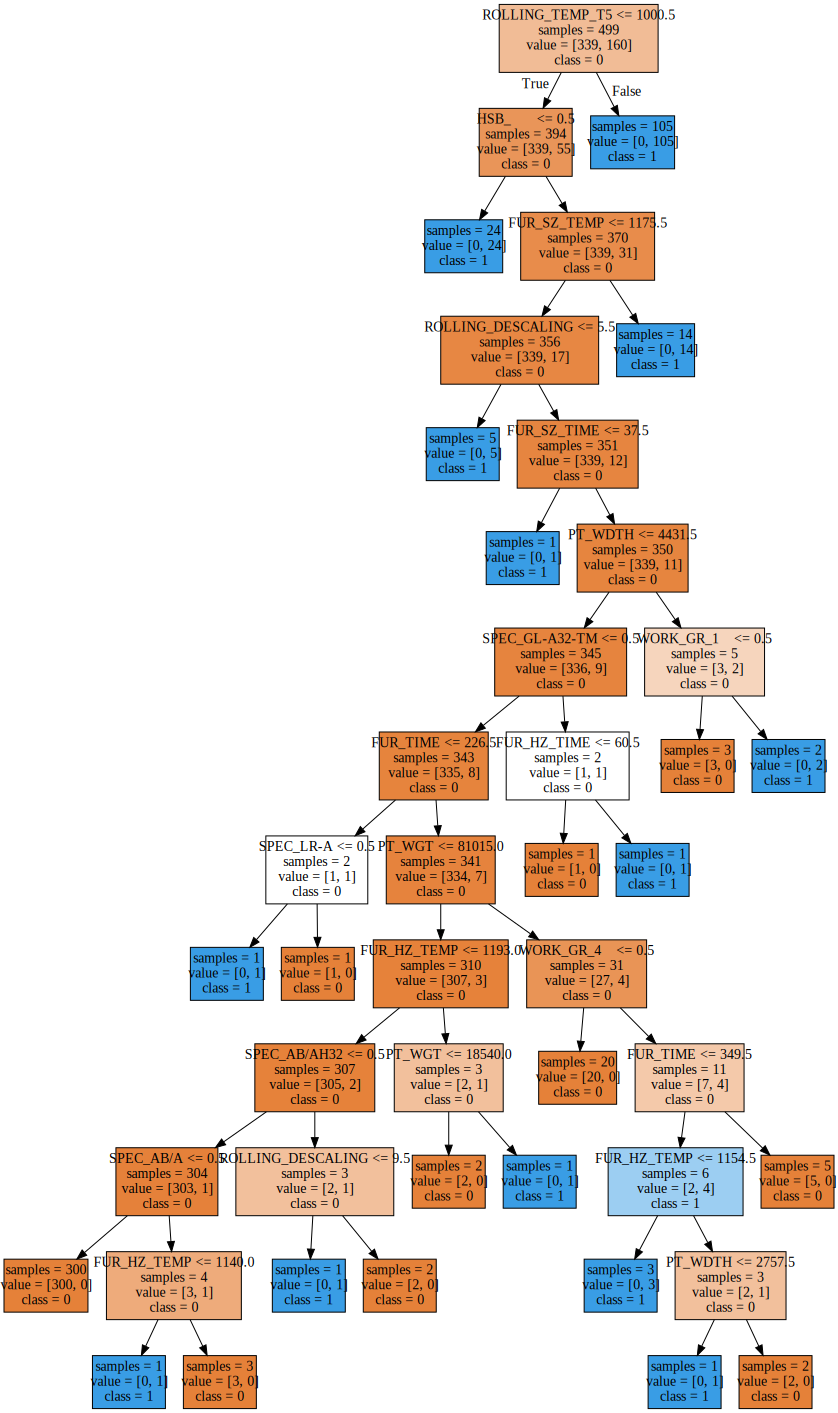

In [19]:
# 트리 이미지
export_graphviz(tree_uncustomized,out_file='tree_uncustomized.dot',class_names=['0','1'],
               feature_names=X_train.columns,impurity=False,filled=True)
os.environ['PATH']+=os.pathsep

with open('tree_uncustomized.dot') as f :
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

매개변수를 default로 두고 생성한 의사결정모델의 예측 정확도는 93%이다.
그러나 의사결정트리를 보면 트리의 깊이가 지나치게 깊어 새로운 데이터에 적용하였을 때, 예측오차가 매우 높을 것으로 예상된다.

이번에는 10-fold CV GridSearch를 통해 매개변수를 탐색하여 최적 의사결정트리 모델을 찾아보자.

In [20]:
parameters={'criterion':('gini','entropy'),
            'min_samples_leaf':[i for i in range(10,30)],
            'max_depth':[i for i in range(1,5)],
            'min_samples_split':[i for i in range(2,4)],
           }
gsearch=GridSearchCV(tree_uncustomized,parameters,cv=10)
gsearch.fit(X_train,y_train)
tree_model=gsearch.best_estimator_
tree_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

In [21]:
tree_fitted = tree_model.predict(X_train)
tree_predicted = tree_model.predict(X_test)

confusion = pd.DataFrame(confusion_matrix(y_test, tree_predicted))
print(confusion)

print('Accuracy on train set: {:.2f}'.format(accuracy_score(y_train, tree_fitted)))
print('Accuracy on test set: {:.2f}'.format(accuracy_score(y_test, tree_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test, tree_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test, tree_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test, tree_predicted)))

     0   1
0  144   0
1   10  61
Accuracy on train set: 0.97
Accuracy on test set: 0.95
Precision: 1.00
Recall: 0.86
F1: 0.92


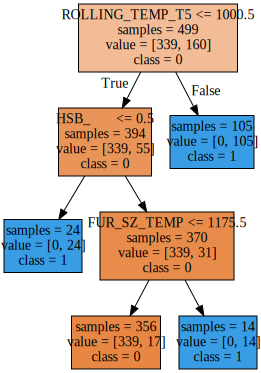

In [22]:
export_graphviz(tree_model,out_file='tree.dot',class_names=['0','1'],
               feature_names=X_train.columns,impurity=False,filled=True)
os.environ['PATH']+=os.pathsep

with open('tree.dot') as f :
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

그리드 탐색을 통한 최적 의사결정트리의 예측 정확도는 95%이다. 또한 재현율도 86%로 매우 양호한 수치이다. 

의사결정트리는 ROLLING_TEMP_T5 / HSB_적용 / FUR_SZ_TEMP 를 기준으로 불량과 양품을 구분한다. 

### 2. 랜덤포레스트

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rf_uncustomized=RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(X_train,y_train)

rf_fitted = rf_uncustomized.predict(X_train)
rf_predicted = rf_uncustomized.predict(X_test)

confusion = pd.DataFrame(confusion_matrix(y_test, rf_predicted))
print(confusion)

print('Accuracy on train set: {:.2f}'.format(accuracy_score(y_train, rf_fitted)))
print('Accuracy on test set: {:.2f}'.format(accuracy_score(y_test, rf_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predicted)))

     0   1
0  140   4
1   13  58
Accuracy on train set: 1.00
Accuracy on test set: 0.92
Precision: 0.94
Recall: 0.82
F1: 0.87


매개변수를 default로 두고 생성한 랜덤 포레스트 모델의 예측 정확도는 92%이다.
그러나 min_samples_leaf=1이므로, 새로운 데이터에 적용하였을 때, 예측오차가 매우 높을 것으로 예상된다.

이번에는 10-fold CV GridSearch를 통해 매개변수를 탐색하여 최적 랜덤포레스트 모델을 찾아보자.

In [25]:
parameters={'criterion':('gini','entropy'),
            'min_samples_leaf':[i*5 for i in range(1,6)],
            'max_depth':[i for i in range(1,10)],
            'n_estimators':[i for i in range(1,10)],
            'n_jobs':[1]
        }
gsearch=GridSearchCV(rf_uncustomized,parameters,cv=10)
gsearch.fit(X_train,y_train)
rf_model=gsearch.best_estimator_
rf_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=1,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [26]:
rf_fitted = rf_model.predict(X_train)
rf_predicted = rf_model.predict(X_test)

confusion = pd.DataFrame(confusion_matrix(y_test, rf_predicted))
print(confusion)

print('Accuracy on train set: {:.2f}'.format(accuracy_score(y_train, rf_fitted)))
print('Accuracy on test set: {:.2f}'.format(accuracy_score(y_test, rf_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predicted)))

     0   1
0  144   0
1   23  48
Accuracy on train set: 0.93
Accuracy on test set: 0.89
Precision: 1.00
Recall: 0.68
F1: 0.81


In [27]:
def plot_feature_importances(feature_importance_model_over0,model):
    n_features=len(feature_importance_model_over0)
    feature_importance_sorted=feature_importance_model_over0.sort_values(by="importance",ascending=True)
    plt.barh(range(n_features),feature_importance_sorted.importance,align="center")
    plt.yticks(np.arange(n_features),feature_importance_sorted.feature)
    plt.xlabel("설명변수 중요도")
    plt.ylabel("설명변수")
    plt.ylim(-1,n_features)

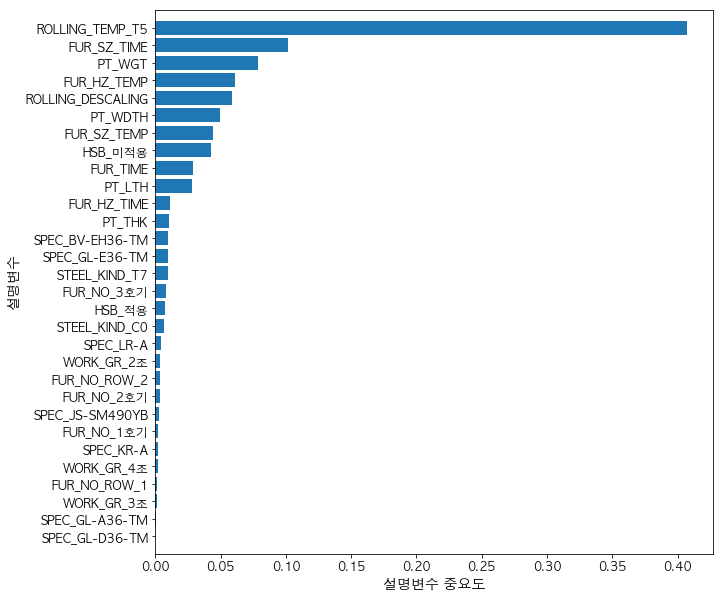

In [28]:
feature_importance_rf=pd.DataFrame()
feature_importance_rf["feature"]=X_train.columns
feature_importance_rf["importance"]=rf_model.feature_importances_
feature_importance_rf_over0=feature_importance_rf[feature_importance_rf['importance']>0]
feature_importance_rf_over0.sort_values(by="importance",ascending=False)
plt.figure(figsize=(10,10))
plot_feature_importances(feature_importance_rf_over0,rf_model)

그리드 탐색을 통한 최적 랜덤 포레스트 모델의 예측 정확도는 89%이다. 그러나 재현율은 68%로 매우 과적합 됨을 알 수 있다.

랜덤포레스트 모델은 ROLLING_TEMP_T5 / FUR_SZ_TEMP / PT_WGT / FUR_HZ_TEMP  등을 기준으로 불량과 양품을 구분한다. 

### 3. 그래디언트 부스팅

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

In [30]:
gb_uncustomized=GradientBoostingClassifier(random_state=1234)
gb_uncustomized.fit(X_train,y_train)

gb_fitted = gb_uncustomized.predict(X_train)
gb_predicted = gb_uncustomized.predict(X_test)

confusion = pd.DataFrame(confusion_matrix(y_test, gb_predicted))
print(confusion)

print('Accuracy on train set: {:.2f}'.format(accuracy_score(y_train, gb_fitted)))
print('Accuracy on test set: {:.2f}'.format(accuracy_score(y_test, gb_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test, gb_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test, gb_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test, gb_predicted)))

     0   1
0  144   0
1    9  62
Accuracy on train set: 1.00
Accuracy on test set: 0.96
Precision: 1.00
Recall: 0.87
F1: 0.93


매개변수를 default로 두고 생성한 GB 모델의 예측 정확도는 96%이다.
그러나 min_samples_leaf=1이므로, 새로운 데이터에 적용하였을 때, 예측오차가 매우 높을 것으로 예상된다.

이번에는 10-fold CV GridSearch를 통해 매개변수를 탐색하여 최적 GB 모델을 찾아보자.

In [31]:
parameters={'learning_rate':[(i+1)/10 for i in range(10)],
            'min_samples_leaf':[i+1 for i in range(3,20,1)],
            'max_depth':[i+1 for i in range(3)],
            'n_estimators':[i+1 for i in range(3,10)]
        }
gsearch=GridSearchCV(gb_uncustomized,parameters,cv=10)
gsearch.fit(X_train,y_train)
gb_model=gsearch.best_estimator_
gb_model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.8, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=8, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=1234, subsample=1.0, verbose=0,
              warm_start=False)

In [32]:
gb_fitted = gb_model.predict(X_train)
gb_predicted = gb_model.predict(X_test)

confusion = pd.DataFrame(confusion_matrix(y_test, gb_predicted))
print(confusion)

print('Accuracy on train set: {:.2f}'.format(accuracy_score(y_train, gb_fitted)))
print('Accuracy on test set: {:.2f}'.format(accuracy_score(y_test, gb_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test, gb_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test, gb_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test, gb_predicted)))

     0   1
0  144   0
1    4  67
Accuracy on train set: 0.99
Accuracy on test set: 0.98
Precision: 1.00
Recall: 0.94
F1: 0.97


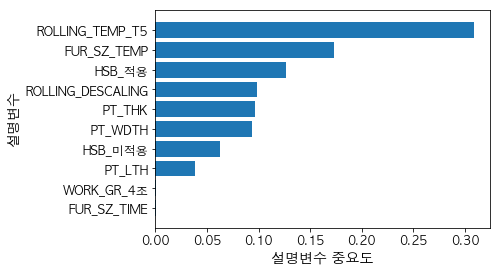

In [33]:
feature_importance_gb=pd.DataFrame()
feature_importance_gb["feature"]=X_train.columns
feature_importance_gb["importance"]=gb_model.feature_importances_
feature_importance_gb_over0=feature_importance_gb[feature_importance_gb['importance']>0]
feature_importance_gb_over0.sort_values(by="importance",ascending=False)
plot_feature_importances(feature_importance_gb_over0,gb_model)

그리드 탐색을 통한 최적 GB 모델의 예측 정확도는 98%이다. 그리고 재현율은 94%로 매우 우수한 모델이다.

GB 모델은 ROLLING_TEMP_T5 / FUR_SZ_TEMP / HSB / ROLLING_DESCALING / PT_THK 등을 기준으로 불량과 양품을 구분한다. 

최종적으로 데이터 탐색, 모델링 기법에서 모두 비슷한 영향 변수가 도출 되었다. 예측정확도, 정밀도, 재현율이 모두 우수한 GB모델에서 선택된 변수와 EDA에서 선택된 변수를 결합하여 불량에 원인이 되는 변수는 아래와 선정한다.

#### 원인변수 : ROLLING_TEMP_T5 / FUR_SZ_TEMP / ROLLING_DESCALING / PT_LTH

# (3) 모델링

SCALE불량 개선을 위한 최적 조건을 찾아보자.

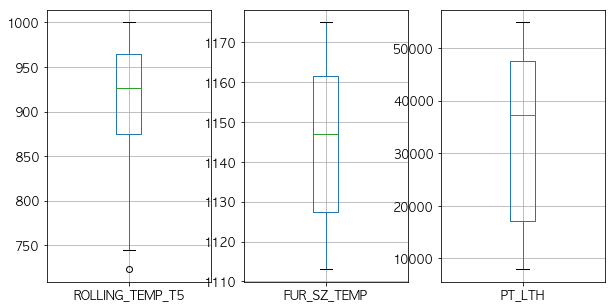

In [34]:
fig, axes = plt.subplots(ncols=3,figsize=(10,5))

ds_scale_0=ds_scale[ds_scale['SCALE']==0]
ds_scale_0.boxplot('ROLLING_TEMP_T5',ax=axes[0]);
ds_scale_0.boxplot('FUR_SZ_TEMP',ax=axes[1]);
ds_scale_0.boxplot('PT_LTH',ax=axes[2]);

#### SCALE 불량을 줄이기 위한 최적 조건은 아래와 같다.
* ROLLING_TEMP_T5 : 880 ~ 960
* FUR_SZ_TEMP : 1130 ~ 1160
* PT_LTH : 18000 ~ 48000